In [15]:
import os
import numpy as np
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

# ---------- SETUP ----------
image_dir = "images"  # 📁 โฟลเดอร์เก็บภาพทั้งหมด
feature_list = []
image_paths = []

# โหลด ResNet50 (ตัด layer สุดท้ายออก, ใช้ global average pooling)
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# ---------- ฟังก์ชันแปลงภาพเป็นเวกเตอร์ ----------
def extract_features(img_path):
    try:
        img = Image.open(img_path).convert("RGB")  # ✅ ใช้ Pillow โดยตรง
        img = img.resize((224, 224))
        x = np.array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        features = model.predict(x, verbose=0)
        return features.flatten()
    
    except Exception as e:
        print(f"❌ ไม่สามารถโหลดภาพ: {img_path} | {e}")
        return None

# ---------- สร้างฐานข้อมูลเวกเตอร์ ----------
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(root, file)
            features = extract_features(img_path)
            if features is not None:
                feature_list.append(features)
                image_paths.append(img_path)

feature_array = np.array(feature_list)
print(f"✅ โหลดเวกเตอร์ภาพทั้งหมดแล้ว: {len(feature_array)} ภาพ")

# ---------- สร้าง Nearest Neighbors Model ----------
nn_model = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='cosine')
nn_model.fit(feature_array)

✅ โหลดเวกเตอร์ภาพทั้งหมดแล้ว: 707 ภาพ


NearestNeighbors(metric='cosine')

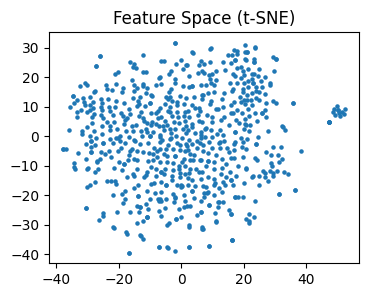

In [24]:
# ทดสอบประสิทธิภาพ

def precision_at_k(true_similar_images, predicted_images, k=5):
    correct = 0
    for pred in predicted_images[:k]:
        if pred in true_similar_images:
            correct += 1
    return correct / k

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30)
embedding_2d = tsne.fit_transform(feature_array)

plt.figure(figsize=(4, 3))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=5)
plt.title("Feature Space (t-SNE)")
plt.show()


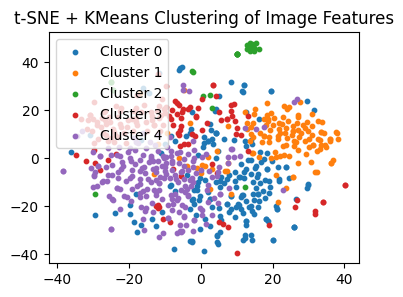

In [26]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# ---------- ใช้ t-SNE ลดมิติเป็น 2D ----------
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(feature_array)

# ---------- ใช้ KMeans จัดกลุ่ม ----------
num_clusters = 5  # 🔧 ลองเริ่มที่ 5 กลุ่ม (ปรับได้)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(feature_array)

# ---------- Plot จุด + สีตามกลุ่ม ----------
plt.figure(figsize=(4, 3))
for i in range(num_clusters):
    idxs = np.where(cluster_labels == i)
    plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1], label=f"Cluster {i}", s=10)

plt.title("t-SNE + KMeans Clustering of Image Features")
plt.legend()
plt.show()

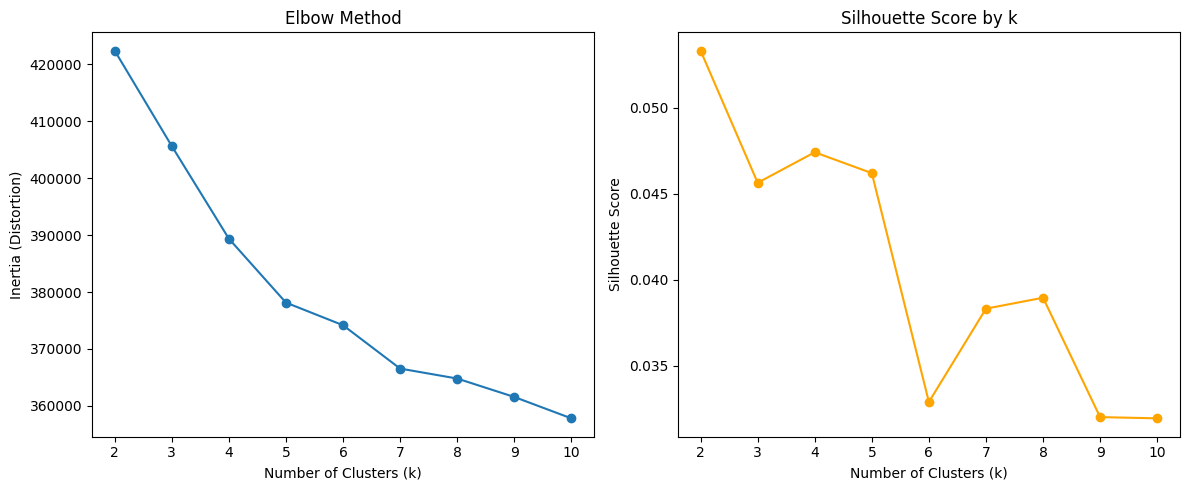


✅ จำนวน cluster ที่เหมาะสมที่สุดตาม Silhouette Score คือ: 2
Best k: 2


In [28]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_optimal_clusters(feature_array, k_min=2, k_max=10):
    """
    ค้นหาจำนวน cluster ที่เหมาะสมโดยใช้ Elbow Method และ Silhouette Score

    Parameters:
        feature_array (np.ndarray): เวกเตอร์ภาพทั้งหมด (n_samples, n_features)
        k_min (int): จำนวน cluster ขั้นต่ำ (เริ่มต้นที่ 2)
        k_max (int): จำนวน cluster สูงสุด

    Returns:
        dict: {
            "best_k": จำนวน cluster ที่ silhouette สูงสุด,
            "silhouette_scores": [score ของแต่ละ k],
            "inertias": [inertia ของแต่ละ k]
        }
    """

    range_n_clusters = list(range(k_min, k_max + 1))
    inertias = []
    sil_scores = []

    for k in range_n_clusters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(feature_array)

        inertia = kmeans.inertia_
        sil = silhouette_score(feature_array, labels)

        inertias.append(inertia)
        sil_scores.append(sil)

    # Plot Elbow + Silhouette
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range_n_clusters, inertias, marker='o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia (Distortion)")
    plt.title("Elbow Method")

    plt.subplot(1, 2, 2)
    plt.plot(range_n_clusters, sil_scores, marker='o', color='orange')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score by k")

    plt.tight_layout()
    plt.show()

    # คืนค่า k ที่ได้ silhouette สูงสุด
    best_k = range_n_clusters[sil_scores.index(max(sil_scores))]
    print(f"\n✅ จำนวน cluster ที่เหมาะสมที่สุดตาม Silhouette Score คือ: {best_k}")

    return {
        "best_k": best_k,
        "silhouette_scores": sil_scores,
        "inertias": inertias
    }

result = find_optimal_clusters(feature_array, k_min=2, k_max=10)
print("Best k:", result["best_k"])


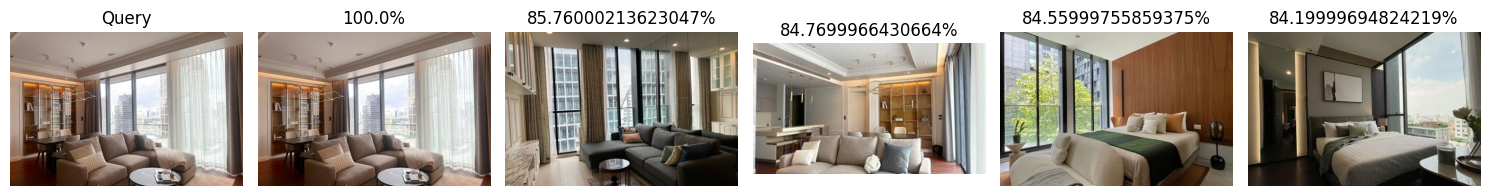

In [19]:
import matplotlib.pyplot as plt
# ---------- ทดสอบ: ใช้ภาพแรกใน dataset ----------
query_image = image_paths[0]
query_feature = extract_features(query_image)
distances, indices = nn_model.kneighbors([query_feature])

# ---------- แสดงภาพผลลัพธ์พร้อม % ความคล้าย ----------
plt.figure(figsize=(15, 4))

# ภาพนำเข้า (Query)
plt.subplot(1, 6, 1)
img = Image.open(query_image)
plt.imshow(img)
plt.title("Query")
plt.axis("off")

# ภาพคล้ายกัน
for idx, i in enumerate(indices[0]):
    sim_score = 1 - distances[0][idx]       # ความคล้าย (1 - cosine distance)
    sim_percent = round(sim_score * 100, 2) # แปลงเป็น %
    plt.subplot(1, 6, idx + 2)
    img = Image.open(image_paths[i])
    plt.imshow(img)
    plt.title(f"{sim_percent}%")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
from PIL import Image

img = Image.open("images/011457/011457_01.jpg")
img = img.resize((224, 224))
img.show()


In [29]:
# # ---------- ทดสอบค้นหาภาพที่คล้ายกัน ----------
# query_image = image_paths[0]  # 🔍 ลองใช้ภาพแรกใน dataset
# query_feature = extract_features(query_image)
# distances, indices = nn_model.kneighbors([query_feature])

# print(f"\n🔍 ผลลัพธ์: ภาพที่คล้ายกับ {query_image}")
# for i in indices[0]:
#     print(f"👉 {image_paths[i]}")